<a href="https://colab.research.google.com/github/alexc957/Tensorflow-2-Practice/blob/Practice/Overfitting_in_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the necesary libraries 

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

### Get the data 

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

--2020-11-02 19:30:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   206MB/s    in 1.1s    

2020-11-02 19:30:17 (206 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
print(num_sentences)
print(len(corpus))
print(corpus[1])


1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


### Create list of sentences, labels and split them into train-test sets   

In [5]:
sentences = []
labels = []
random.shuffle(corpus)
for x in range(training_size):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

split = int(test_portion*training_size)


test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [6]:
print(vocab_size)
print(word_index['i'])

138693
1


#### Get a embedding matrix already trained

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-11-02 19:36:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   179MB/s    in 1.9s    

2020-11-02 19:36:52 (179 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [8]:
print(len(embeddings_matrix))


138694


### Build the model

In [10]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim,input_length=max_length,weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64,5,activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1,activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13869400  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,934,553
Trainable params: 65,153
Non-trainable params: 13,869,400
_______________________________________

In [11]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 29s - loss: 0.5686 - accuracy: 0.6977 - val_loss: 0.5318 - val_accuracy: 0.7269
Epoch 2/50
4500/4500 - 28s - loss: 0.5275 - accuracy: 0.7319 - val_loss: 0.5166 - val_accuracy: 0.7402
Epoch 3/50
4500/4500 - 30s - loss: 0.5128 - accuracy: 0.7423 - val_loss: 0.5169 - val_accuracy: 0.7389
Epoch 4/50
4500/4500 - 29s - loss: 0.5018 - accuracy: 0.7513 - val_loss: 0.5060 - val_accuracy: 0.7472
Epoch 5/50
4500/4500 - 33s - loss: 0.4928 - accuracy: 0.7558 - val_loss: 0.5108 - val_accuracy: 0.7458
Epoch 6/50
4500/4500 - 31s - loss: 0.4847 - accuracy: 0.7619 - val_loss: 0.5039 - val_accuracy: 0.7494
Epoch 7/50
4500/4500 - 29s - loss: 0.4806 - accuracy: 0.7635 - val_loss: 0.5034 - val_accuracy: 0.7486
Epoch 8/50
4500/4500 - 28s - loss: 0.4743 - accuracy: 0.7680 - val_loss: 0.5084 - val_accuracy: 0.7504
Epoch 9/50
4500/4500 - 28s - loss: 0.4708 - accuracy: 0.7709 - val_loss: 0.5037 - val_accuracy: 0.7507
Epoch 10/50
4500/4500 - 28s - loss: 0.4667 - accuracy: 0.7725 - val_loss:

<Figure size 432x288 with 0 Axes>

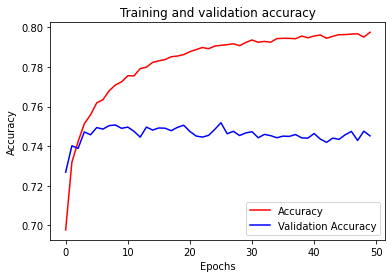

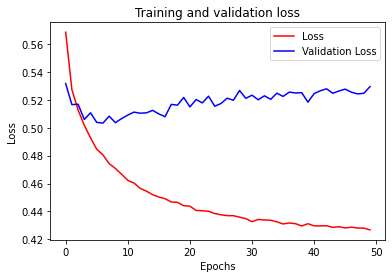

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
